In [ ]:
!pip install opencv-python
!pip install keras
!pip install tensorflow

In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
from keras.datasets import cifar10


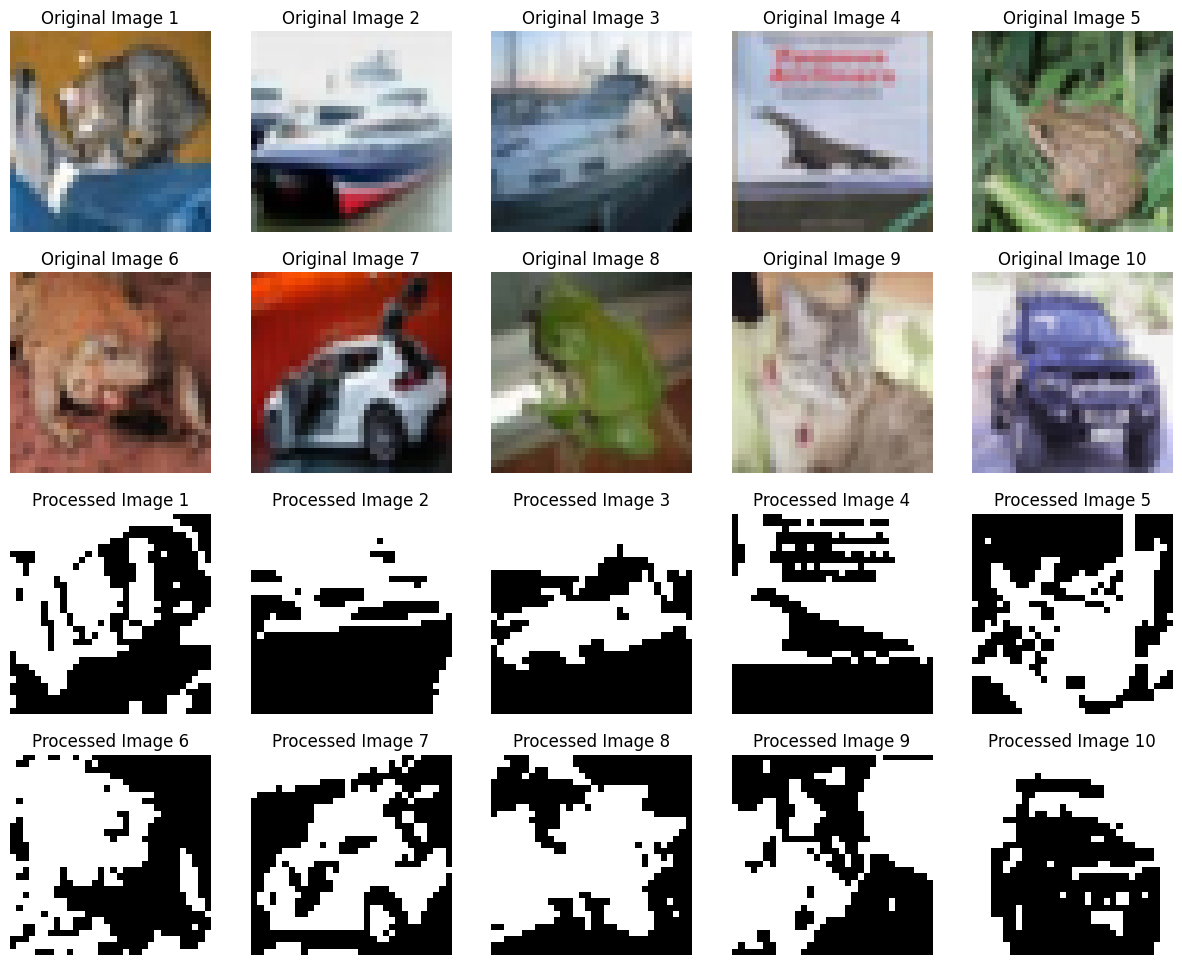

In [2]:
import cv2
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from skimage import color, exposure, filters

# Load CIFAR-10 dataset
(X_train_org, Y_train_org), (X_test_org, Y_test_org) = cifar10.load_data()

X_train = np.copy(X_train_org)
X_test = np.copy(X_test_org)

Y_train=Y_train_org.reshape(Y_train_org.shape[0])
Y_test=Y_test_org.reshape(Y_test_org.shape[0])

# Function to preprocess images using Canny edge detection
def preprocess_images(images):
    processed_images = []
    for image in images:
        image = color.rgb2gray(image)
        image = (image * 255).astype(np.uint8)

        image_eq = exposure.equalize_hist(image)
        threshold_value = filters.threshold_otsu(image_eq)
        binary_image = image_eq > threshold_value
        processed_images.append(binary_image)
    return np.array(processed_images)

X_train_processed = preprocess_images(X_train)
X_test_processed = preprocess_images(X_test)

# Display the images
plt.figure(figsize=(15, 12))

for i in range(10):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title('Original Image {}'.format(i + 1))
    plt.axis('off')

    plt.subplot(4, 5, i + 11)
    plt.imshow(X_test_processed[i], cmap='gray')
    plt.title('Processed Image {}'.format(i + 1))
    plt.axis('off')

plt.savefig("otsu_thresh.png")
plt.show()

In [8]:
print(X_train.shape)
print(X_train_processed.shape)

X_train = X_train_processed
X_test = X_test_processed

(50000, 32, 32)
(50000, 32, 32)


In [ ]:
from tmu.models.classification.vanilla_classifier import TMClassifier
from time import time

num_clauses=2000
T=500
s=10.0
patch_size=16
max_included_literals=32
weighted_clauses=True

tm = TMClassifier(
    number_of_clauses=num_clauses,
    T=T,
    s=s,
    max_included_literals=max_included_literals,
    platform="GPU",
    weighted_clauses=True,
    patch_dim=(patch_size, patch_size)
)

epochs = 100

for epoch in range(epochs):
        start_training = time()
        tm.fit(X_train_processed, Y_train)
        stop_training = time()

        start_testing = time()
        Y_test_predicted, Y_test_scores = tm.predict(X_test_processed, return_class_sums=True)
        stop_testing = time()

        result_test = 100*(Y_test_scores.argmax(axis=1) == Y_test).mean()

        print("#%d Accuracy: %.2f%% Training: %.2fs Testing: %.2fs" % (epoch+1, result_test, stop_training-start_training, stop_testing-start_testing))

        np.savetxt("CIFAR10Otsu_%d_%d_%d_%.1f_%d_%d_%d.txt" % (epoch+1, num_clauses, T, s, patch_size, max_included_literals, weighted_clauses), Y_test_scores, delimiter=',')


2023-12-02 11:32:19,097 - tmu.clause_bank.clause_bank_cuda - DEBUG - [0.140956ms] - Compiling CUDA Module 'cuda/calculate_clause_outputs_predict.cu'.
2023-12-02 11:32:19,238 - tmu.clause_bank.clause_bank_cuda - DEBUG - [0.139495ms] - Compiling CUDA Module 'cuda/calculate_clause_outputs_update.cu'.
2023-12-02 11:32:19,389 - tmu.clause_bank.clause_bank_cuda - DEBUG - [0.149821ms] - Compiling CUDA Module 'cuda/clause_feedback.cu'.
2023-12-02 11:32:19,530 - tmu.clause_bank.clause_bank_cuda - DEBUG - [0.139516ms] - Compiling CUDA Module 'cuda/tools.cu'.
2023-12-02 11:32:19,674 - tmu.clause_bank.clause_bank_cuda - INFO - Loading compiled CUDA module from '/tmp/tm_kernels/9f17b3fbf8b1682fbb779952d634532cbe458e44.ptx'.
2023-12-02 11:32:19,675 - tmu.clause_bank.clause_bank_cuda - INFO - Loading compiled CUDA module from '/tmp/tm_kernels/fbdc3b0da45d49a13d8b05b7a93918512733d356.ptx'.
2023-12-02 11:32:19,676 - tmu.clause_bank.clause_bank_cuda - INFO - Loading compiled CUDA module from '/tmp/tm_ke